In [1]:
import numpy as np
import boto3
import sagemaker
import io
import sagemaker.amazon.common as smac
import os
import pandas as pd
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings('ignore')



from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sagemaker import get_execution_role



get_ipython().system('{sys.executable} -m pip install sagemaker -U')

sagemaker_session = sagemaker.Session()
role = get_execution_role() 

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[01/28/25 19:27:00] INFO     Found credentials from IAM Role:                                   ]8;id=818342;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=27604;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[01/28/25 19:27:04] INFO     Found credentials from IAM Role:                                   ]8;id=236723;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=32036;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=389976;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=701914;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [2]:
# Read csv from s3.
from io import StringIO
s3 = boto3.resource('s3')
bucket = 'nimbleai-whizlabs'
object_key = 'fraudTrain.csv'

# Load the data into a pandas dataframe 
csv_obj = s3.Object(bucket, object_key)
csv_string = csv_obj.get()['Body'].read().decode('utf-8')

fraud_df = pd.read_csv(StringIO(csv_string))

[01/28/25 19:27:21] INFO     Found credentials from IAM Role:                                   ]8;id=152315;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=948387;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Skipping checksum validation. Response did not contain one of the  ]8;id=381270;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py\httpchecksum.py]8;;\:]8;id=964508;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/httpchecksum.py#481\481]8;;\
                             following algorithms: ['crc32', 'sha1', 'sha256'].                                    

In [3]:
fraud_df['trans_date_trans_time'] = pd.to_datetime(fraud_df['trans_date_trans_time'])
print(fraud_df.dtypes['trans_date_trans_time'])

datetime64[ns]


In [4]:
#deriving hour, day and year-month from trans_date_trans_time
fraud_df['trans_hour'] = fraud_df['trans_date_trans_time'].dt.hour
fraud_df['trans_day_of_week'] = fraud_df['trans_date_trans_time'].dt.dayofweek +1
fraud_df['trans_day_of_week'] = fraud_df['trans_day_of_week'].astype(int)

fraud_df['trans_year_month'] = fraud_df['trans_date_trans_time'].dt.to_period('M')

#getting age from DOB

fraud_df['dob']= pd.to_datetime(fraud_df['dob'])
fraud_df['age'] = ((fraud_df['trans_date_trans_time'] - fraud_df['dob']).dt.days/365.25).astype(int)

In [5]:
fraud_df['category'] = fraud_df['category'].astype('category')
fraud_df['gender'] = fraud_df['gender'].astype('category')
fraud_df['is_fraud'] = fraud_df['is_fraud'].astype('category')

In [6]:
fraud_df.shape

(1048575, 27)

In [7]:
# Creating bins for age
custom_bins = [13, 19, 32, 42, 50,62 , float('inf')]
custom_labels = ['Teenagers', 'Young Adults', 'Adults', 'Middle-aged', 'Seniors', 'Retired']

# Apply the binning to create a new 'age_category' column
fraud_df['age_category'] = pd.cut(fraud_df['age'], bins=custom_bins, labels=custom_labels, right=False)

print(fraud_df[['age', 'age_category']].tail())

         age  age_category
1048570   76       Retired
1048571   20  Young Adults
1048572   67       Retired
1048573   29  Young Adults
1048574   22  Young Adults


In [8]:
x =  [ 'amt', 'gender','lat', 'long', 'city_pop',  'trans_hour','trans_day_of_week', 'age','is_fraud','age_category']
fraud_df = pd.get_dummies(fraud_df[x], drop_first=True)
fraud_df.columns

Index(['amt', 'lat', 'long', 'city_pop', 'trans_hour', 'trans_day_of_week',
       'age', 'gender_M', 'is_fraud_1', 'age_category_Young Adults',
       'age_category_Adults', 'age_category_Middle-aged',
       'age_category_Seniors', 'age_category_Retired'],
      dtype='object')

In [9]:
fraud_df.shape

(1048575, 14)

In [13]:
!pip install imblearn
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 93.7 MB/s eta 0:00:00


Fold 1: AUC = 0.9797, F1 = 0.6600, Precision = 0.7514, Recall = 0.5885
Fold 2: AUC = 0.9836, F1 = 0.6636, Precision = 0.7492, Recall = 0.5955
Fold 3: AUC = 0.9818, F1 = 0.6616, Precision = 0.7161, Recall = 0.6149
Fold 4: AUC = 0.9796, F1 = 0.6809, Precision = 0.7263, Recall = 0.6408
Fold 5: AUC = 0.9842, F1 = 0.6780, Precision = 0.8056, Recall = 0.5854

Optimized XGBoost with SMOTE:
Mean AUC: 0.9818 ± 0.0019
Mean F1: 0.6688 ± 0.0088
Mean Precision: 0.7497 ± 0.0310
Mean Recall: 0.6050 ± 0.0206


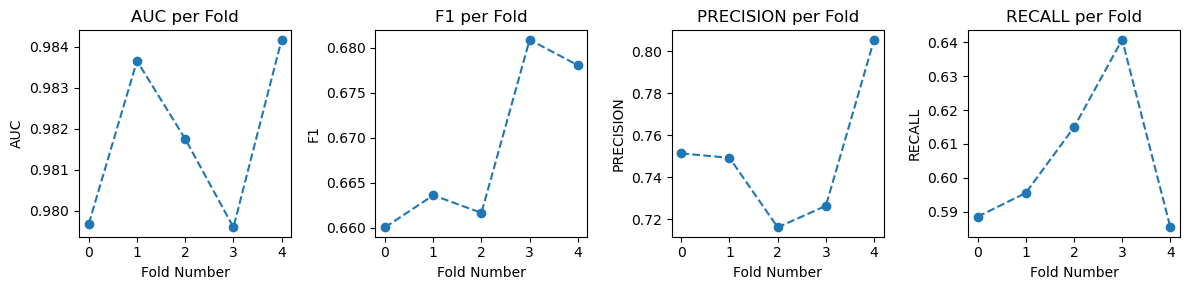

In [14]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load dataset
predictors = [
    'amt', 'city_pop', 'trans_hour', 'age', 'gender_M', 'lat', 'long',
    'trans_day_of_week', 'age_category_Young Adults', 'age_category_Adults',
    'age_category_Middle-aged', 'age_category_Seniors', 'age_category_Retired'
]
X = fraud_df[predictors]
y = fraud_df['is_fraud_1']

# Configure SMOTE (adjust sampling_strategy based on experiments)
smote = SMOTE(sampling_strategy=0.2, random_state=42, k_neighbors=5)

# K-Fold configuration
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics
metrics = {'auc': [], 'f1': [], 'precision': [], 'recall': []}

for fold, (train_idx, valid_idx) in enumerate(kf.split(X), 1):
    # Split data
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    # Apply SMOTE only to training data
    X_res, y_res = smote.fit_resample(X_train, y_train)
    
    # Calculate dynamic class weights
    class_ratio = (y_res == 0).sum() / (y_res == 1).sum()
    
    # Configure XGBoost
    model = XGBClassifier(
        objective='binary:logistic',
        n_estimators=300,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.2,
        reg_lambda=0.2,
        scale_pos_weight=class_ratio,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    # Train model
    model.fit(X_res, y_res)
    
    # Get predictions and probabilities
    probas = model.predict_proba(X_valid)[:, 1]
    
    # Find optimal threshold for F1 score
    precision, recall, thresholds = precision_recall_curve(y_valid, probas)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Calculate final predictions
    preds = (probas >= best_threshold).astype(int)
    
    # Store metrics
    metrics['auc'].append(roc_auc_score(y_valid, probas))
    metrics['f1'].append(f1_score(y_valid, preds))
    metrics['precision'].append(precision_score(y_valid, preds))
    metrics['recall'].append(recall_score(y_valid, preds))
    
    print(f"Fold {fold}: AUC = {metrics['auc'][-1]:.4f}, F1 = {metrics['f1'][-1]:.4f}, "
          f"Precision = {metrics['precision'][-1]:.4f}, Recall = {metrics['recall'][-1]:.4f}")

# Print final results
print("\nOptimized XGBoost with SMOTE:")
print(f"Mean AUC: {np.mean(metrics['auc']):.4f} ± {np.std(metrics['auc']):.4f}")
print(f"Mean F1: {np.mean(metrics['f1']):.4f} ± {np.std(metrics['f1']):.4f}")
print(f"Mean Precision: {np.mean(metrics['precision']):.4f} ± {np.std(metrics['precision']):.4f}")
print(f"Mean Recall: {np.mean(metrics['recall']):.4f} ± {np.std(metrics['recall']):.4f}")